In [1]:
!pip install gensim transformers torch matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 39.1 MB/s eta 0:00:00


In [2]:
import logging
import warnings
from google.colab import drive

# Suppress logging warnings from torchao which might complain about missing Triton
logging.getLogger("torchao").setLevel(logging.ERROR)
logging.getLogger("torchao.kernel.intmm").setLevel(logging.ERROR)

# Suppress standard warnings to keep output clean
warnings.filterwarnings("ignore")

import os
import zipfile
import urllib.request
import gensim
import gensim.downloader as api
from gensim.models import KeyedVectors
import torch
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertModel, BertTokenizer, CLIPModel, CLIPProcessor
import numpy as np
from huggingface_hub import hf_hub_download
from PIL import Image
import requests
from io import BytesIO
import pickle # Added pickle import


print("Libraries imported successfully.")
print(f"Gensim version: {gensim.__version__}")
print(f"Torch version: {torch.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

Libraries imported successfully.
Gensim version: 4.4.0
Torch version: 2.9.0+cu126
Scikit-learn version: 1.6.1


# Introduction: Evolution and Geometry of Text Embeddings

**Author**: Shiyang Lai


This notebook explores the evolution of text representation in natural language processing. We will examine how text embeddings have developed from static word vectors to dynamic, contextual representations and multimodal understanding.

**Key Concepts to be Covered:**

1.  **Static Models (Word2Vec/GloVe):** We will look at how words are mapped to fixed vectors where semantic relationships are preserved (e.g., vector arithmetic analogies).
2.  **Contextual Models (BERT):** We will explore how modern transformer-based models generate embeddings that change based on the surrounding context of a word.
3.  **Multimodal Encoders (CLIP):** We will demonstrate how text and image embeddings are aligned in a shared vector space.
4.  **Geometric Analysis:** We will visualize positional encodings (sinusoidal) and perform vector arithmetic to understand the geometry of these embedding spaces.

By the end of this notebook, you will have a practical understanding of how machines represent meaning through vectors and how these representations have improved over time.

## Static Embeddings: Word2Vec & GloVe


> What is the difference between Word2Vec and GloVe models?

In [ ]:
# Load the pre-trained GloVe model (50 dimensions)
print("Loading GloVe model...")
glove_model = api.load('glove-wiki-gigaword-50')
print("GloVe model loaded successfully.")

# Find the top 5 words most similar to 'king'
print("\nTop 5 words most similar to 'king':")
similar_to_king = glove_model.most_similar('king', topn=5)
for word, score in similar_to_king:
    print(f"{word}: {score:.4f}")

# Find the top 5 words most similar to 'computer'
print("\nTop 5 words most similar to 'computer':")
similar_to_computer = glove_model.most_similar('computer', topn=5)
for word, score in similar_to_computer:
    print(f"{word}: {score:.4f}")

# Calculate similarity scores
sim_cat_dog = glove_model.similarity('cat', 'dog')
sim_cat_car = glove_model.similarity('cat', 'car')

print(f"\nSimilarity between 'cat' and 'dog': {sim_cat_dog:.4f}")
print(f"Similarity between 'cat' and 'car': {sim_cat_car:.4f}")

Loading GloVe model...
[==================================================] 100.0% 66.0/66.0MB downloaded
GloVe model loaded successfully.

Top 5 words most similar to 'king':
prince: 0.8236
queen: 0.7839
ii: 0.7746
emperor: 0.7736
son: 0.7667

Top 5 words most similar to 'computer':
computers: 0.9165
software: 0.8815
technology: 0.8526
electronic: 0.8126
internet: 0.8060

Similarity between 'cat' and 'dog': 0.9218
Similarity between 'cat' and 'car': 0.3638


## Temporal (Diachronic) Word Embeddings

So far, we have seen *static* embeddings, where each word is represented by a single vector regardless of time or context.

However, word meanings can evolve historically. For example, words like *“gay”*, *“cloud”*, or *“virus”* have taken on new meanings over time. **Temporal (diachronic) embeddings** explicitly model this phenomenon by learning *separate embeddings for different time periods*.

In this section, we will:

1. Download a **pretrained diachronic embedding model**
2. Extract embeddings for the same word across different years
3. Measure and visualize **semantic drift over time**

Unlike contextual embeddings, these vectors vary **across years**, not across sentences.

Here is the data: https://drive.google.com/drive/folders/1vES1mLmOdiEANoBBkx8fgO33-sz8oZ03?usp=drive_link.

> How are diachronic word embedding models (e.g., HistWord) trained?

In [ ]:
drive.mount('/content/drive')

# TODO: Please change this to the exact path of shared folder in Drive
BASE_DIR = "/content/drive/MyDrive/en_sgns/"

# Define paths for both vectors (.npy) and vocabulary (.pkl) files
# Assuming file names are like '1800-w.npy' and '1800-vocab.pkl'
paths_config = {
    1800: {"vectors": "1800-w.npy", "vocab": "1800-vocab.pkl"},
    1900: {"vectors": "1900-w.npy", "vocab": "1900-vocab.pkl"},
    1990: {"vectors": "1990-w.npy", "vocab": "1990-vocab.pkl"},
}

# Create actual file paths dictionary
file_paths = {}
for y, files in paths_config.items():
    file_paths[y] = {
        "vectors": os.path.join(BASE_DIR, files["vectors"]),
        "vocab": os.path.join(BASE_DIR, files["vocab"]),
    }

# Verify paths exist
for y, p_dict in file_paths.items():
    print(f"Year {y}:")
    print(f"  Vectors exists? {os.path.exists(p_dict['vectors'])} -> {p_dict['vectors']}")
    print(f"  Vocab exists? {os.path.exists(p_dict['vocab'])} -> {p_dict['vocab']}")

# Update the 'paths' variable to 'file_paths' for use in the next cell
paths = file_paths

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Year 1800:
  Vectors exists? True -> /content/drive/MyDrive/en_sgns/1800-w.npy
  Vocab exists? True -> /content/drive/MyDrive/en_sgns/1800-vocab.pkl
Year 1900:
  Vectors exists? True -> /content/drive/MyDrive/en_sgns/1900-w.npy
  Vocab exists? True -> /content/drive/MyDrive/en_sgns/1900-vocab.pkl
Year 1990:
  Vectors exists? True -> /content/drive/MyDrive/en_sgns/1990-w.npy
  Vocab exists? True -> /content/drive/MyDrive/en_sgns/1990-vocab.pkl


In [ ]:
emb = {}
for y, p_dict in paths.items(): # 'paths' now contains dicts of 'vectors' and 'vocab' paths
    print(f"Loading {y} from {p_dict['vectors']} and {p_dict['vocab']}...")
    try:
        # Load vectors (NumPy array)
        word_vectors = np.load(p_dict['vectors'])

        # Load vocabulary (list of words) using pickle
        with open(p_dict['vocab'], 'rb') as f:
            vocabulary = pickle.load(f)

        # Create a KeyedVectors object
        kv = KeyedVectors(vector_size=word_vectors.shape[1])
        kv.add_vectors(vocabulary, word_vectors)
        emb[y] = kv

        print(f"Loaded {y}: vocab={len(emb[y].key_to_index):,}, dim={emb[y].vector_size}")
    except Exception as e:
        print(f"Error loading {y}: {e}")

Loading 1800 from /content/drive/MyDrive/en_sgns/1800-w.npy and /content/drive/MyDrive/en_sgns/1800-vocab.pkl...
Loaded 1800: vocab=100,000, dim=300
Loading 1900 from /content/drive/MyDrive/en_sgns/1900-w.npy and /content/drive/MyDrive/en_sgns/1900-vocab.pkl...
Loaded 1900: vocab=100,000, dim=300
Loading 1990 from /content/drive/MyDrive/en_sgns/1990-w.npy and /content/drive/MyDrive/en_sgns/1990-vocab.pkl...
Loaded 1990: vocab=100,000, dim=300


In [ ]:
# Compare the same word across years
def cos(u, v):
    return cosine_similarity(u.reshape(1,-1), v.reshape(1,-1))[0,0]

word = "gay"   # try also: "cloud", "virus", "mouse", "amazon"

y1, y2, y3 = 1800, 1900, 1990

if word not in emb[y1] or word not in emb[y2] or word not in emb[y3]:
    print(f"'{word}' not found in one of the years. Try another word.")
else:
    sim = cos(emb[y1][word], emb[y2][word])
    print(f"Cosine similarity for '{word}' between {y1} and {y2}: {sim:.4f}")
    sim = cos(emb[y2][word], emb[y3][word])
    print(f"Cosine similarity for '{word}' between {y2} and {y3}: {sim:.4f}")

Cosine similarity for 'gay' between 1800 and 1900: 0.4781
Cosine similarity for 'gay' between 1900 and 1990: 0.1776


In [ ]:
# Neighborhood shift
def show_neighbors(word, year, topn=8):
    print(f"\nTop neighbors of '{word}' in {year}:")
    for w, s in emb[year].most_similar(word, topn=topn):
        print(f"  {w:>12s}  {s:.4f}")

word = "cloud"
show_neighbors(word, 1800, topn=8)
show_neighbors(word, 1900, topn=8)
show_neighbors(word, 1990, topn=8)


Top neighbors of 'cloud' in 1800:
        clouds  0.6545
          mist  0.6319
     enveloped  0.5922
         smoke  0.5640
           fog  0.5418
         flash  0.5090
           sky  0.4766
         glare  0.4686

Top neighbors of 'cloud' in 1900:
        clouds  0.6747
          mist  0.6144
          haze  0.5350
           fog  0.5165
         mists  0.5116
           sky  0.4691
       drizzle  0.4519
         smoke  0.4514

Top neighbors of 'cloud' in 1990:
        clouds  0.6204
          mist  0.5316
          dust  0.4669
           sky  0.4570
        fleecy  0.4522
         smoke  0.4514
          haze  0.4140
           fog  0.4133


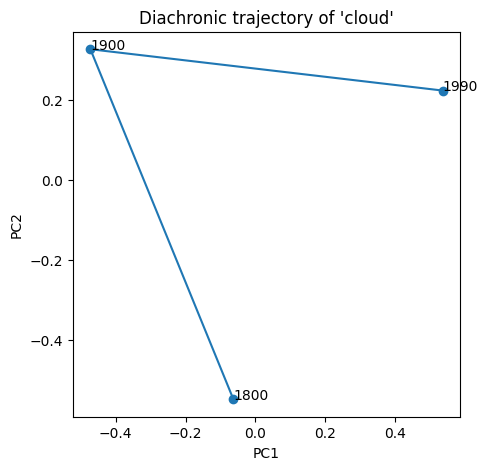

In [ ]:
# A small trajectory plot
word = "cloud"
years = sorted(emb.keys())

# Collect vectors (only for years where the word exists)
vecs = []
ys = []
for y in years:
    if word in emb[y]:
        vecs.append(emb[y][word])
        ys.append(y)

vecs = np.vstack(vecs)

coords = PCA(n_components=2).fit_transform(vecs)

plt.figure(figsize=(5,5))
plt.plot(coords[:,0], coords[:,1], marker="o")
for i, y in enumerate(ys):
    plt.text(coords[i,0], coords[i,1], str(y))
plt.title(f"Diachronic trajectory of '{word}'")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


## Contextual Embeddings: Transformers & BERT

So far, we have seen two kinds of variation in word embeddings:

* **Static embeddings**: one vector per word
* **Diachronic embeddings**: one vector per word *per time period*

Modern language models introduce a third kind of variation: **context**.

Transformer-based models such as **BERT** produce *contextual embeddings*, meaning that the representation of a word depends on the sentence it appears in. As a result, the *same word* can have *different vectors even within the same time period*, depending on its local linguistic context.

In this section, we will:

1. Load a pretrained BERT model
2. Extract token-level embeddings
3. Compare the embedding of the same word across different sentences

> What is the difference between BERT, GPT, and T5?

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")
model = BertModel.from_pretrained("bert-large-uncased")
model.eval()

print("BERT-large loaded successfully.")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

BERT-large loaded successfully.


In [ ]:
def contextual_embedding(sentence, target_word):
    """
    Return a contextual embedding for target_word in sentence.
    """
    inputs = tokenizer(sentence, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    hidden_states = outputs.last_hidden_state[0]  # (seq_len, hidden_dim)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    target_tokens = tokenizer.tokenize(target_word)

    # find matching token spans
    spans = []
    for i in range(len(tokens) - len(target_tokens) + 1):
        if tokens[i:i+len(target_tokens)] == target_tokens:
            spans.append((i, i+len(target_tokens)))

    if not spans:
        raise ValueError(f"'{target_word}' not found in tokenized sentence.")

    vecs = [hidden_states[s:e].mean(dim=0).cpu().numpy() for s, e in spans]
    return np.mean(vecs, axis=0), tokens


In [ ]:
word = "bank"

s1 = "I went to the bank to deposit my paycheck."
s2 = "We sat on the bank of the river and watched the water."

v1, tokens1 = contextual_embedding(s1, word)
v2, tokens2 = contextual_embedding(s2, word)

print("Sentence 1 tokens:", tokens1)
print("Sentence 2 tokens:", tokens2)

print(f"\nCosine similarity between '{word}' embeddings across contexts:")
print(cos(v1, v2))

Sentence 1 tokens: ['[CLS]', 'i', 'went', 'to', 'the', 'bank', 'to', 'deposit', 'my', 'pay', '##che', '##ck', '.', '[SEP]']
Sentence 2 tokens: ['[CLS]', 'we', 'sat', 'on', 'the', 'bank', 'of', 'the', 'river', 'and', 'watched', 'the', 'water', '.', '[SEP]']

Cosine similarity between 'bank' embeddings across contexts:
0.61096317


In [ ]:
# static vs contextual
print("Static GloVe similarity (bank vs bank):",
      glove_model.similarity("bank", "bank"))

print("Contextual BERT similarity (bank@finance vs bank@river):",
      cos(v1, v2))

Static GloVe similarity (bank vs bank): 1.0
Contextual BERT similarity (bank@finance vs bank@river): 0.61096317


## Multimodal Text Embeddings: CLIP

Transformer encoders like BERT produce **contextual text embeddings**. Many modern generative models (including diffusion models) use a *different kind* of text embedding: one that is explicitly trained to align **text and images** in a shared vector space.

**CLIP** (Contrastive Language–Image Pretraining) learns:

* a **text encoder** that maps text → vector
* an **image encoder** that maps image → vector
  so that matching text–image pairs are close in embedding space.

In diffusion-based image generation, a CLIP-like text encoder often provides the **conditioning signal** that guides the denoising process (i.e., “what to draw”).

In [ ]:
clip_name = "openai/clip-vit-base-patch32"  # standard + manageable on CPU
clip_processor = CLIPProcessor.from_pretrained(clip_name)
clip_model = CLIPModel.from_pretrained(clip_name)
clip_model.eval()

print("CLIP loaded:", clip_name)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIP loaded: openai/clip-vit-base-patch32


In [ ]:
def clip_text_embedding(texts):
    """
    texts: list[str]
    returns: (n, d) numpy array of normalized text embeddings
    """
    inputs = clip_processor(text=texts, return_tensors="pt", padding=True)
    with torch.no_grad():
        feats = clip_model.get_text_features(**inputs)
    feats = feats / feats.norm(dim=-1, keepdim=True)  # normalize
    return feats.cpu().numpy()

def clip_image_embedding(images):
    """
    images: list[PIL.Image]
    returns: (n, d) numpy array of normalized image embeddings
    """
    inputs = clip_processor(images=images, return_tensors="pt")
    with torch.no_grad():
        feats = clip_model.get_image_features(**inputs)
    feats = feats / feats.norm(dim=-1, keepdim=True)  # normalize
    return feats.cpu().numpy()

In [ ]:
# Text-text similarity in CLIP space
texts = [
    "a photo of a dog",
    "a photo of a cat",
    "a photo of a laptop",
    "a photo of a golden retriever",
]

E = clip_text_embedding(texts)

print("Cosine similarity matrix (CLIP text embeddings):")
S = cosine_similarity(E)
for i, t in enumerate(texts):
    row = "  ".join([f"{S[i,j]:.3f}" for j in range(len(texts))])
    print(f"{i}: {t:28s} | {row}")


Cosine similarity matrix (CLIP text embeddings):
0: a photo of a dog             | 1.000  0.931  0.818  0.852
1: a photo of a cat             | 0.931  1.000  0.811  0.801
2: a photo of a laptop          | 0.818  0.811  1.000  0.720
3: a photo of a golden retriever | 0.852  0.801  0.720  1.000


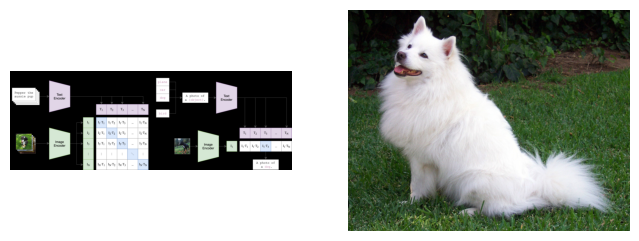

In [ ]:
def load_image(url):
    # Add a user-agent to avoid occasional blocks
    req = urllib.request.Request(url, headers={"User-Agent": "Mozilla/5.0"})
    with urllib.request.urlopen(req) as r:
        return Image.open(r).convert("RGB")

# Use stable, known-to-exist image URLs
img_urls = [
    "https://raw.githubusercontent.com/openai/CLIP/main/CLIP.png",
    "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg",
]

images = [load_image(u) for u in img_urls]

plt.figure(figsize=(8,3))
for i, im in enumerate(images):
    plt.subplot(1, len(images), i+1)
    plt.imshow(im)
    plt.axis("off")
plt.show()

In [ ]:
candidate_texts = [
    "a diagram about CLIP",
    "a photo of a dog",
    "a photo of a cat",
    "a photo of a laptop",
]

T = clip_text_embedding(candidate_texts)   # (m, d)
I = clip_image_embedding(images)           # (n, d)

sim = I @ T.T  # cosine similarity since vectors are normalized

for i in range(sim.shape[0]):
    best = int(np.argmax(sim[i]))
    print(f"Image {i} best match: {candidate_texts[best]}   score={float(sim[i, best]):.4f}")


Image 0 best match: a diagram about CLIP   score=0.2535
Image 1 best match: a photo of a dog   score=0.2800


In [ ]:
# Prompt engineering changes embedding direction
p1 = "a photo of a cat"
p2 = "a photo of a black cat"
p3 = "a photo of a cat in a courtroom"

E = clip_text_embedding([p1, p2, p3])
print("sim(cat, black cat)   =", float(E[0] @ E[1]))
print("sim(cat, courtroom cat)=", float(E[0] @ E[2]))

sim(cat, black cat)   = 0.8867920637130737
sim(cat, courtroom cat)= 0.8052395582199097


## Geometry of Embedding Spaces: When Linearity Works — and When It Breaks

So far, we have examined several families of embeddings. In this final section, we focus not on *models*, but on the **geometry** of the spaces they induce.

A central question is whether semantic concepts correspond to **linear directions** in embedding space. In some cases, a concept can be represented as a consistent vector offset. In other cases, meaning is distributed in more complex, non-linear structures that cannot be captured by a single direction.

We will examine both phenomena:

1. Concepts that are well-approximated by **linear directions**
2. Concepts for which **linearity fails**

In [ ]:
# Define a simple gender direction using GloVe
gender_pairs = [
    ("man", "woman"),
    ("king", "queen"),
    ("father", "mother"),
    ("boy", "girl"),
]

diffs = [glove_model[w1] - glove_model[w2] for w1, w2 in gender_pairs]
gender_direction = np.mean(diffs, axis=0)

def proj(word, direction):
    return np.dot(glove_model[word], direction) / np.linalg.norm(direction)

for w in ["man", "woman", "king", "queen", "doctor", "nurse"]:
    print(f"{w:>8s}  projection={proj(w, gender_direction):.3f}")

     man  projection=0.126
   woman  projection=-2.085
    king  projection=1.646
   queen  projection=-1.407
  doctor  projection=-0.205
   nurse  projection=-1.753


This shows that:

a single linear direction captures a meaningful semantic axis

many words project consistently along that axis

This is why linear probes often work well for attributes like gender or sentiment.

In [ ]:
# Analogy as vector arithmetic (king − man + woman ≈ queen)
glove_model.most_similar(
    positive=["king", "woman"],
    negative=["man"],
    topn=5
)

[('queen', 0.8523604273796082),
 ('throne', 0.7664334177970886),
 ('prince', 0.7592144012451172),
 ('daughter', 0.7473883628845215),
 ('elizabeth', 0.7460219860076904)]

In [ ]:
time_pairs = [
    ("morning", "night"),
    ("yesterday", "tomorrow"),
    ("early", "late"),
]

time_diffs = [glove_model[w1] - glove_model[w2] for w1, w2 in time_pairs]
time_direction = np.mean(time_diffs, axis=0)

for w in ["morning", "afternoon", "evening", "night"]:
    print(f"{w:>12s}  projection={proj(w, time_direction):.3f}")


     morning  projection=0.768
   afternoon  projection=0.949
     evening  projection=0.050
       night  projection=-1.261


In [ ]:
def get_subword_span(tokens, target_tokens):
    """Return list of (start, end) spans where target_tokens matches tokens."""
    spans = []
    for i in range(len(tokens) - len(target_tokens) + 1):
        if tokens[i:i+len(target_tokens)] == target_tokens:
            spans.append((i, i+len(target_tokens)))
    return spans

def bert_phrase_embedding(sentence, phrase):
    """
    Extract a contextual embedding for a multi-token phrase (e.g., '10 o'clock')
    by mean-pooling over the matched subword tokens in the final layer.
    """
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        out = model(**inputs)
    hs = out.last_hidden_state[0]  # (seq_len, hidden_dim)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    phrase_tokens = tokenizer.tokenize(phrase)  # WordPiece tokens
    spans = get_subword_span(tokens, phrase_tokens)
    if not spans:
        raise ValueError(f"Phrase '{phrase}' not found. Tokens={tokens}")

    vecs = [hs[s:e].mean(dim=0).cpu().numpy() for s, e in spans]
    return np.mean(vecs, axis=0)

In [ ]:
# Multiple contexts to reduce sentence-specific noise
contexts = [
    # daily routine
    "I woke up at {}.",
    "I went to bed at {}.",
    "I usually eat lunch at {}.",

    # scheduling
    "The meeting started at {}.",
    "The train arrives at {}.",
    "Class begins at {}.",

    # social / conversational
    "She called me at {}.",
    "We decided to leave at {}.",
    "They finally arrived at {}.",

    # institutional
    "The interview was scheduled at {}.",
    "The store opens at {}.",

    # narrative
    "It was quiet at {}.",
    "Nothing much happens at {}.",
]


times = [f"{h} o'clock" for h in range(1, 13)]  # 1..12

E = []
for t in times:
    vecs = []
    for c in contexts:
        sent = c.format(t)
        vecs.append(bert_phrase_embedding(sent, t))
    E.append(np.mean(vecs, axis=0))  # average across contexts

E = np.vstack(E)  # (12, hidden_dim)
print("Built embeddings:", E.shape)

Built embeddings: (12, 1024)


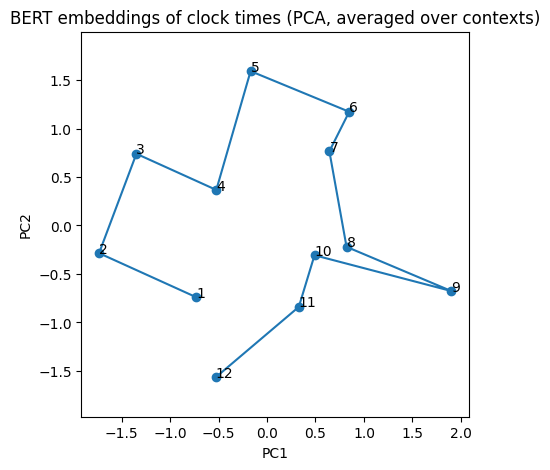

In [ ]:
coords = PCA(n_components=2).fit_transform(E)

plt.figure(figsize=(5,5))
plt.plot(coords[:,0], coords[:,1], marker="o")
for i, t in enumerate(times):
    plt.text(coords[i,0], coords[i,1], t.split()[0])  # label with hour only
plt.title("BERT embeddings of clock times (PCA, averaged over contexts)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.axis("equal")
plt.show()

In [ ]:
S = cosine_similarity(E)  # 12x12

def top_neighbors(i, k=3):
    idx = np.argsort(-S[i])  # descending
    idx = [j for j in idx if j != i][:k]
    return [(times[j], float(S[i, j])) for j in idx]

for hour in [0, 1, 10, 11]:  # 1,2,11,12 (0-indexed)
    print(f"\nNeighbors of {times[hour]}:")
    for n, s in top_neighbors(hour, k=4):
        print(f"  {n:10s}  {s:.3f}")

# specifically check adjacency + wrap
def sim(a, b):  # a,b are indices 0..11
    return float(S[a, b])

print("\nAdjacency checks:")
print("sim(12, 1) =", sim(11, 0))
print("sim(12, 11)=", sim(11,10))
print("sim(1, 2)  =", sim(0, 1))
print("sim(6, 7)  =", sim(5, 6))


Neighbors of 1 o'clock:
  11 o'clock  0.980
  2 o'clock   0.979
  3 o'clock   0.976
  12 o'clock  0.975

Neighbors of 2 o'clock:
  3 o'clock   0.982
  1 o'clock   0.979
  12 o'clock  0.974
  4 o'clock   0.973

Neighbors of 11 o'clock:
  8 o'clock   0.984
  10 o'clock  0.982
  7 o'clock   0.981
  1 o'clock   0.980

Neighbors of 12 o'clock:
  11 o'clock  0.980
  1 o'clock   0.975
  2 o'clock   0.974
  10 o'clock  0.968

Adjacency checks:
sim(12, 1) = 0.9749160408973694
sim(12, 11)= 0.9796001315116882
sim(1, 2)  = 0.9791240692138672
sim(6, 7)  = 0.9842361807823181
